In [46]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Use bo4ais library
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

from utils import ps_to_speed, norm_to_ps

# Check

In [83]:
speed_grid = torch.load("data/ice_speed_grid_casey_YX.pt", weights_only = False)

In [14]:
in_example = torch.tensor(
    [
    [1304900., -209150.],
    [1315700., -215000.],
    [2200400., -1100150.]
    ], dtype = torch.float32
)

interpolation_input = ps_to_speed(in_example)

torch.nn.functional.grid_sample(
    # the source (regular) grid is the input
    # [N, C, H, W]
    input = speed_grid[-1, :, :].unsqueeze(0).unsqueeze(0),
    # the target (irregular) grid (points) is the query
    # [N, q (H), W, 2] q number of queries
    grid = interpolation_input.unsqueeze(0).unsqueeze(2), 
    mode = 'bilinear', 
    align_corners = True)

# 1.506
# 1.643
# 99.72

tensor([[[[ 1.5063],
          [ 1.6426],
          [99.7232]]]])

# Load data

We have subsetted the data for a 1400 x 1400 km region.

In [15]:
# Change to double as recommended by BoTorch
ice = torch.load("data/ice_thickness_points_casey.pt", weights_only = False).double()

# skiway_x_norm, skiway_y_norm = 0.7425144608040001, 0.4736784387760001
# location in larger domain
skiway_x_norm, skiway_y_norm = 0.8160817577171429, 0.48119888484000006

skiway = torch.tensor([[skiway_x_norm, skiway_y_norm]])

## Reduce data

In [84]:
REDUCE_RATE = 1000
# subsample points
ice_reduced = ice[::REDUCE_RATE]
# run with reduced version first
print(ice_reduced.shape)
# ice_reduced[:, 0] are x locations from [0, 1]
# ice_reduced[:, 1] are y locations from [0, 1]
# ice_reduced[:, 2] are ice thickness in metres

torch.Size([8279, 3])


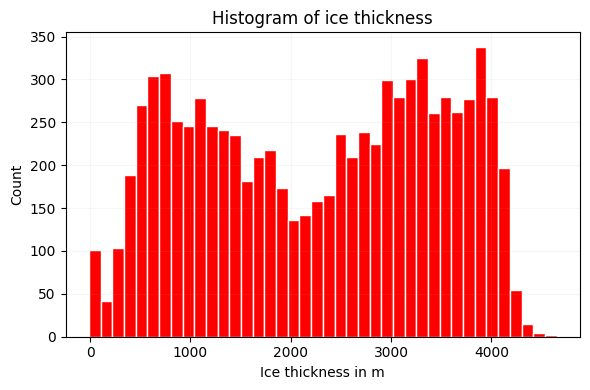

In [85]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.hist(ice_reduced[:, 2], bins = 40, edgecolor = 'white', color = "red")
ax.set_xlabel('Ice thickness in m')                  
ax.set_ylabel('Count')
ax.set_title('Histogram of ice thickness')
ax.grid(alpha = 0.1)
plt.tight_layout()
plt.show()

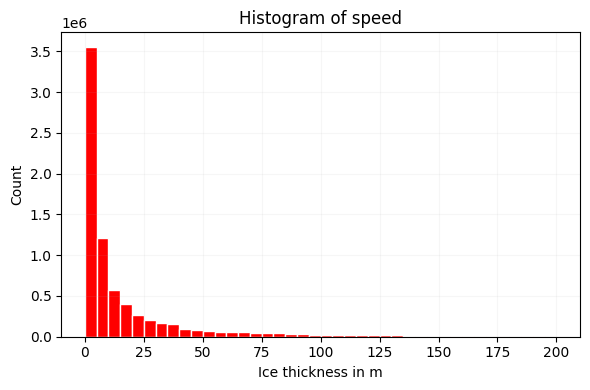

In [87]:
fig, ax = plt.subplots(figsize = (6, 4))
# NOTE: restrict range
ax.hist(speed_grid[-1, :, :].view(-1), bins = 40, edgecolor = 'white', color = "red", range = (0, 200))
ax.set_xlabel('Ice thickness in m')                  
ax.set_ylabel('Count')
ax.set_title('Histogram of speed')
ax.grid(alpha = 0.1)
plt.tight_layout()
plt.show()

In [88]:
ice_reduced_normalised = ice_reduced[:, 2] / 1200

print(ice_reduced_normalised.std())
print(ice_reduced_normalised.var())

tensor(1.0067, dtype=torch.float64)
tensor(1.0134, dtype=torch.float64)


# Fit GP

In [89]:
gp = SingleTaskGP(
    # X: locations
    train_X = ice_reduced[:, 0:2],
    # Y: thickness, unsqueeze to retain explicit dimension
    # normalise manually
    train_Y = ice_reduced[:, 2].unsqueeze(-1) / 1200,
    # input is already normalised to [0, 1]
)

mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

# optimises the GP hyperparameters
# saves gp model with hyperparameters
# Matern(ν = 2.5) kernel with ARD by default
# 13 mins for 8000k points
fit_gpytorch_mll(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (lengthscale_prior): LogNormalPrior()
      (raw_lengthscale_constraint): GreaterThan(2.500E-02)
    )
    (outcome_transform): Standardize()
  )
)

In [20]:
# --- hyperparameters in the model space (NOTE: usually standardized) ---
const_mean = gp.mean_module.constant.detach().cpu().squeeze()
noise_var  = gp.likelihood.noise.detach().cpu().squeeze()  
lengthscales = gp.covar_module.lengthscale.detach().cpu() 

print(f"constant mean = {const_mean.item():.4g}")
print(f"noise var = {noise_var.item():.4g}")
print(f"lengthscales = {lengthscales.view(-1).tolist()}")

constant mean = 0.1831
noise var = 0.02953
lengthscales = [0.028510350760551056, 0.03649066525503517]


# Initialise aquisition function

In [114]:
from botorch.acquisition import UpperConfidenceBound

UCB = UpperConfidenceBound(
    model = gp,
    beta = 10.0  # controls the trade-off between exploration and exploitation
)

# mu + beta * sigma
# data not scaled ?
# higher beta -> more exploration i.e. focus on data gaps

In [115]:
# domain is 0 to 1
N_side = 120
# N_side**2 candidate points
side = torch.linspace(0, 1, N_side)
x, y = torch.meshgrid(side, side, indexing = 'xy')
X_points_long = torch.stack([x.flatten(), y.flatten()], dim = -1)
# batch_shape × q × d with q = 1: pointswise 
X_candidates = X_points_long.unsqueeze(1)

acq_values_UCB = UCB(X_candidates)
acq_values_UCB_2d = acq_values_UCB.reshape(N_side, N_side).detach().numpy()

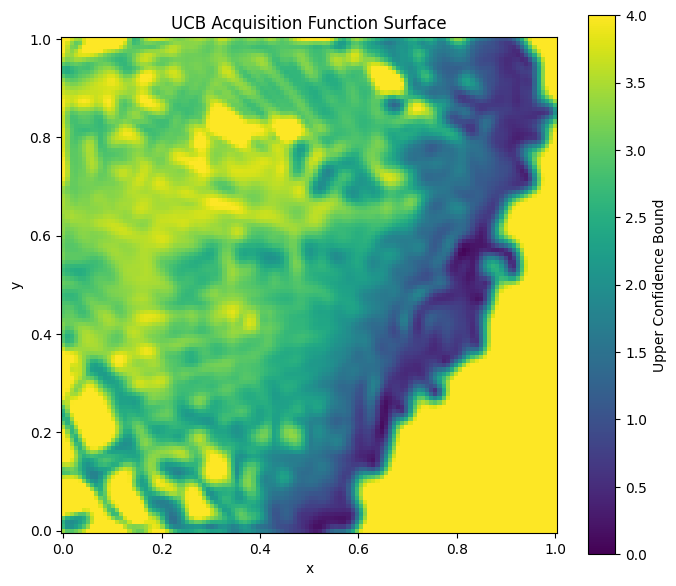

In [116]:
plt.figure(figsize = (8, 7))
plt.pcolormesh(side, side, acq_values_UCB_2d, shading = 'auto', cmap = 'viridis', vmin = 0, vmax = 4)
plt.colorbar(label = "Upper Confidence Bound")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal', adjustable = 'box')
plt.title("UCB Acquisition Function Surface")
plt.show()

# Custom Aquisition function

See https://botorch.org/docs/tutorials/custom_acquisition/

Difference if we want to use q-functions or regular aquisition functions

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from botorch.acquisition.analytic import AnalyticAcquisitionFunction
from botorch.models.model import Model

# Requires speed grid
speed_grid = torch.load("data/ice_speed_grid_casey_YX.pt", weights_only = False)

def sigmoid_through_points(w, speed_low = 0.0, weight_low = 1.0, speed_high = 100.0, weight_high = 1.0):
    """
    Map w -> (0,1) with a sigmoid so that f(speed_low) = weight_low and f(speed_high) = weight_high.
    Defaults give ~0.2 at 0 and ~0.99 by 100.
    """
    # guard probs into (0,1)
    eps = 1e-6
    weight_low = float(min(max(weight_low, eps), 1 - eps))
    weight_high = float(min(max(weight_high, eps), 1 - eps))

    def logit(p): return math.log(p / (1 - p))
    a = (logit(weight_high) - logit(weight_low)) / (speed_high - speed_low)
    b = logit(weight_low) - a * speed_low
    return torch.sigmoid(a * w + b)

class WeightedUCB(AnalyticAcquisitionFunction):
    """
    We are weighting UCB by the flux.
    UCB(X) * weight(X), where weight is bilinearly interpolated from a raster field.
    UCB = mu + sqrt(beta * sigma^2). Works with q=1 and batched evaluation.
    """
    def __init__(self, model: Model, beta: float = 2.0):
        super().__init__(model = model)
        self.beta = beta
        # self.field = field_module

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X: batch_shape x q x d  (q must be 1 for analytic UCB)
        posterior = self.model.posterior(X)
        mean = posterior.mean.squeeze(-1)          # -> batch_shape x q
        var  = posterior.variance.squeeze(-1)      # -> batch_shape x q
        ucb  = mean + torch.sqrt(self.beta * var)  # -> batch_shape x q

        # Interpolated weights from field
        # w = self.field(X)                          # -> batch_shape x q

        # X is shape (N_long, q = 1, 2)
        # X_dense
        X_dense = X.view(-1, 2)

        X_ps = norm_to_ps(X_dense)
        X_for_interpolation = ps_to_speed(X_ps) # -> (batch_shape * q), 2

        speed = torch.nn.functional.grid_sample(
            # the source grid (regular grid) is the input
            # [N, C, H, W]
            input = speed_grid[-1, :, :].unsqueeze(0).unsqueeze(0),
            # the target (irregular) grid (points) is the query
            # [N, q (H), W, 2] q number of queries
            grid = X_for_interpolation.unsqueeze(0).unsqueeze(2), 
            mode = 'bilinear', 
            align_corners = True)
        
        # Remove first two singleton dimensions
        w = sigmoid_through_points(speed.squeeze(0).squeeze(0))
        print(w.max())
        
        # Multiply and reduce q dimension (q = 1)
        return (ucb * w).squeeze(-1)               # -> batch_shape
    
WUCB = WeightedUCB(
    model = gp,
    beta = 2.0  # controls the trade-off between exploration and exploitation
)

tensor(nan)


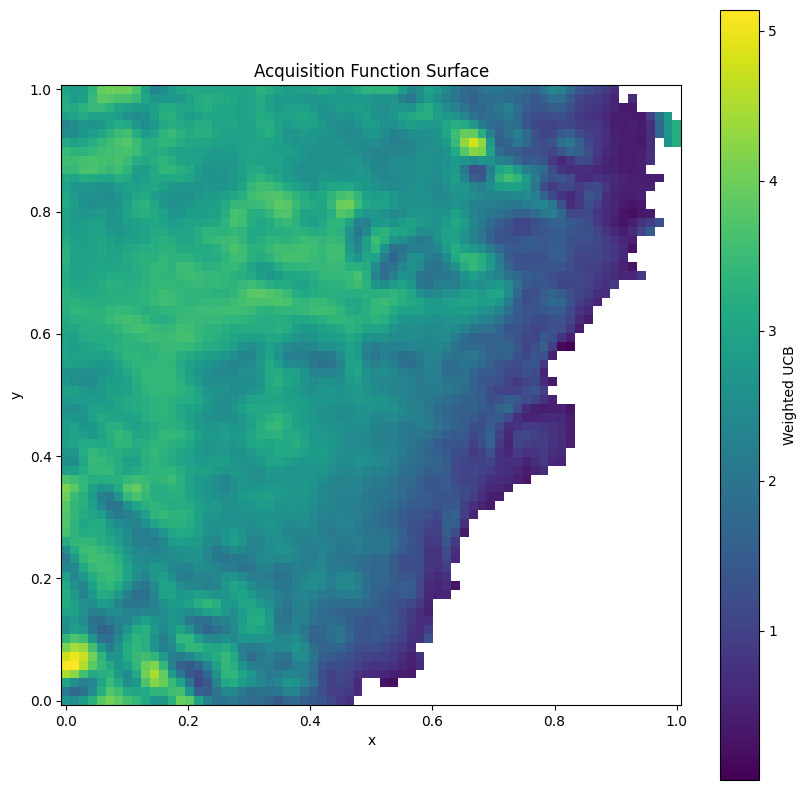

In [94]:
acq_values_WUCB = WUCB(X_candidates)

acq_values_WUCB_2d = acq_values_WUCB.reshape(N_side, N_side).detach().numpy()

plt.figure(figsize = (10, 10))
plt.pcolormesh(side, side, acq_values_WUCB_2d, shading = 'auto', cmap = 'viridis')
plt.colorbar(label = "Weighted UCB")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Acquisition Function Surface")
plt.gca().set_aspect('equal', adjustable = 'box')
plt.show()

/tmp/ipykernel_922429/320416384.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


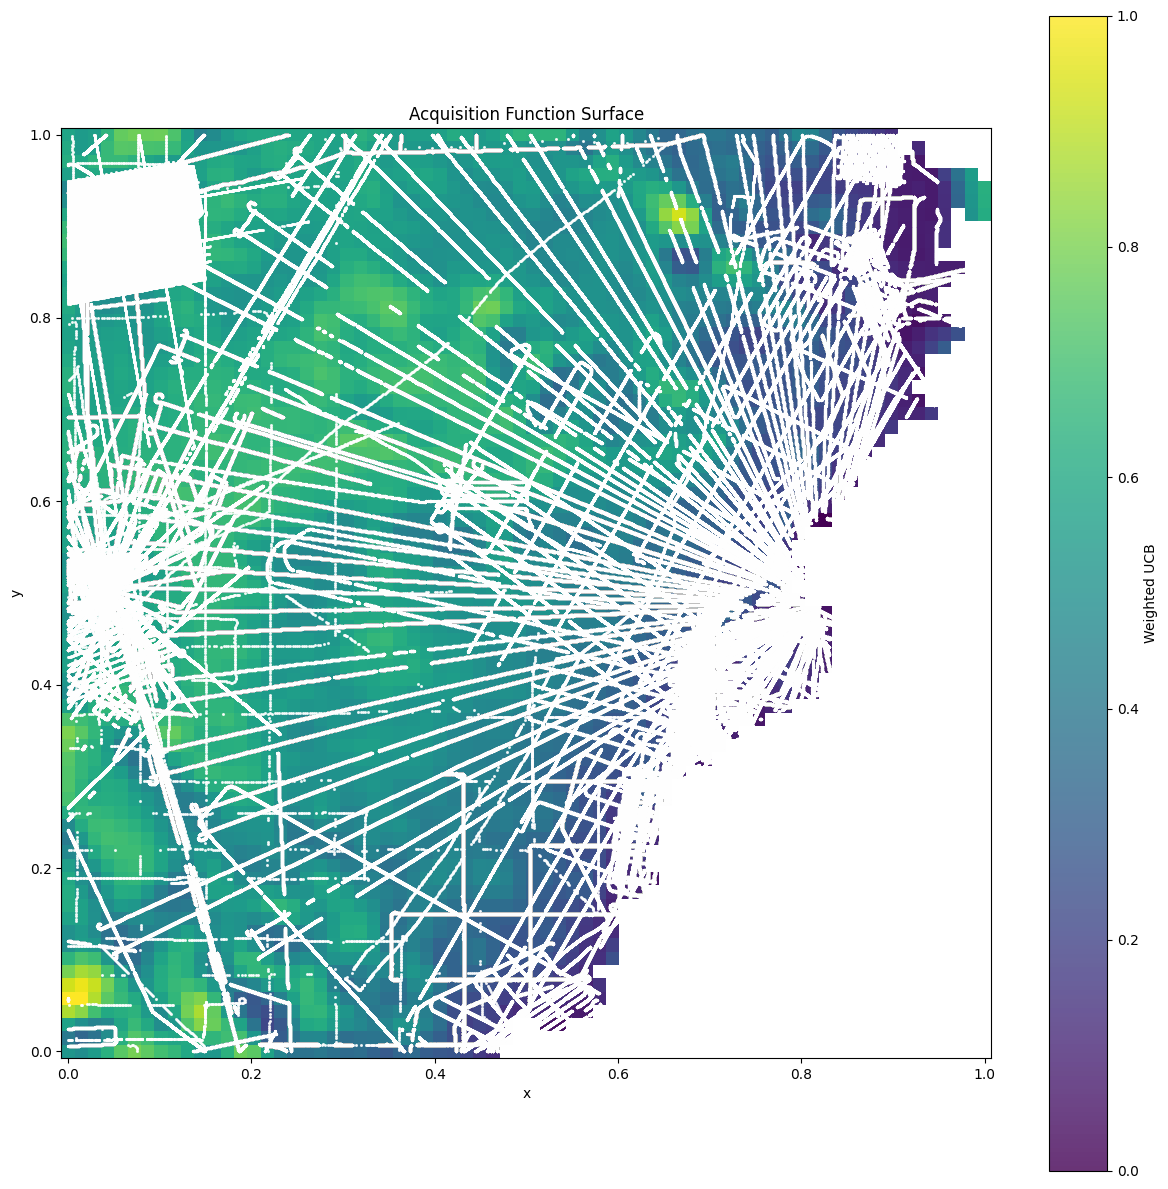

In [ ]:
plt.figure(figsize = (15, 15))
plt.pcolormesh(side, side, acq_values_WUCB_2d, shading = 'auto', cmap = 'viridis')

# REDUCE_RATE = 1 (all 8M -> Takes 2 minutes to render)
REDUCE_RATE = 1 
plt.scatter(
    ice[:, 0][::REDUCE_RATE], 
    ice[:, 1][::REDUCE_RATE], 
    c = "white", # "white", ice[:, 2]
    s = 1.5, alpha = 0.8, cmap = 'Oranges') # 'BuPu'

plt.colorbar(label = "Weighted UCB")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Acquisition Function Surface")
plt.gca().set_aspect('equal', adjustable = 'box')

plt.savefig("figures/acq_surface_some_data.png", dpi = 600, bbox_inches=  'tight', pad_inches = 0.02)
plt.show()

/tmp/ipykernel_922429/4189150194.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


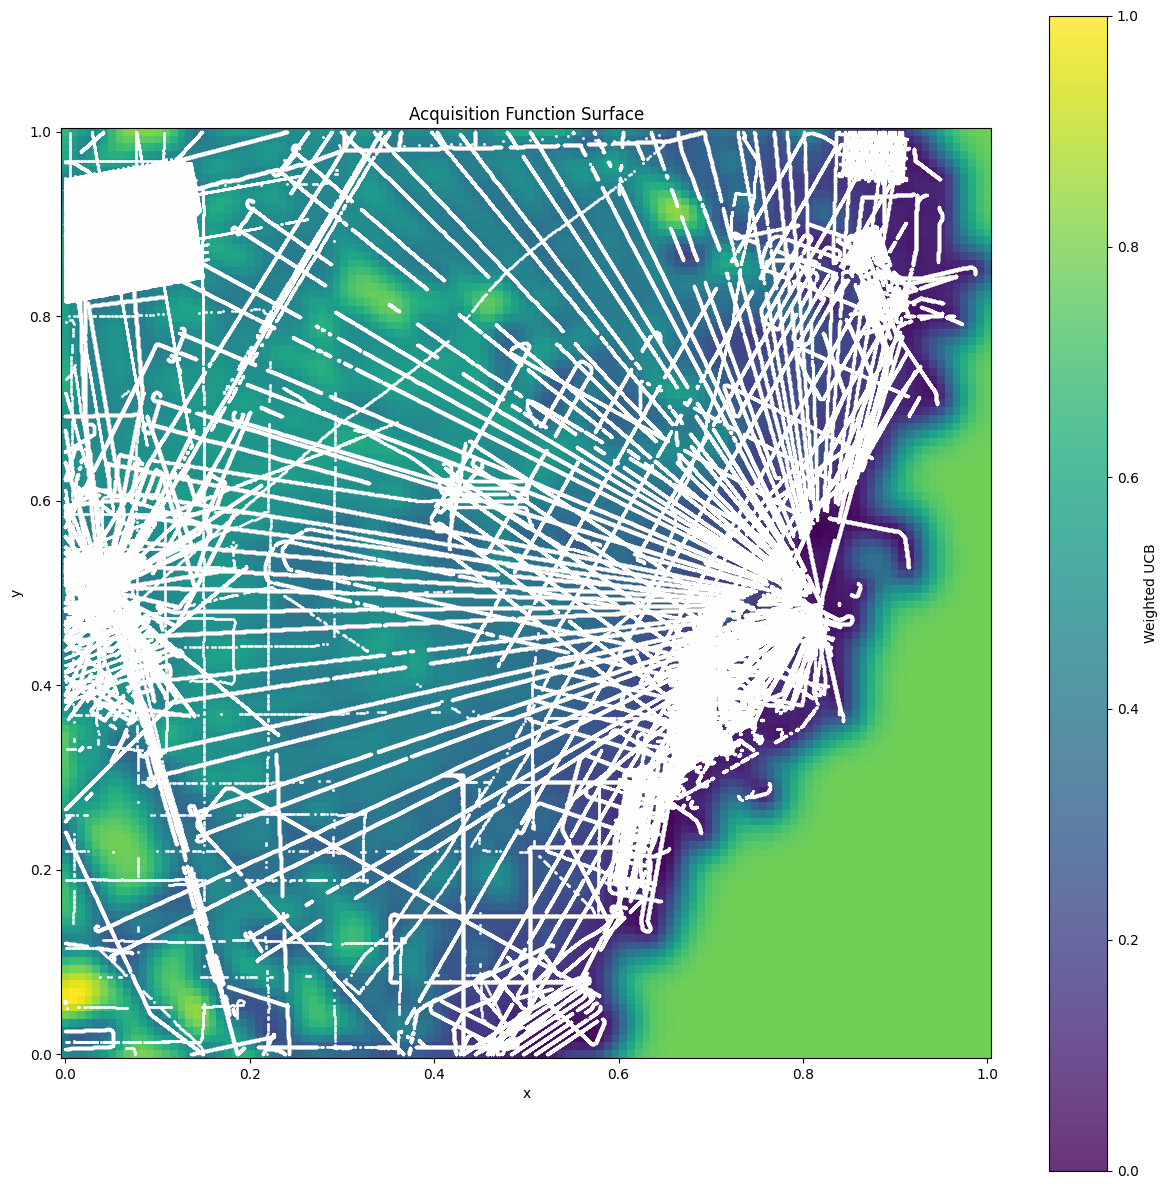

In [117]:
plt.figure(figsize = (15, 15))
plt.pcolormesh(side, side, acq_values_UCB_2d, shading = 'auto', cmap = 'viridis')

# REDUCE_RATE = 1 (all 8M -> Takes 2 minutes to render)
REDUCE_RATE = 1 
plt.scatter(
    ice[:, 0][::REDUCE_RATE], 
    ice[:, 1][::REDUCE_RATE], 
    c = "white", # "white", ice[:, 2]
    s = 1.5, alpha = 0.8, cmap = 'Oranges') # 'BuPu'

plt.colorbar(label = "Weighted UCB")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Acquisition Function Surface")
plt.gca().set_aspect('equal', adjustable = 'box')

plt.savefig("figures/acq_surface_UCB_all_data.png", dpi = 600, bbox_inches=  'tight', pad_inches = 0.02)
plt.show()

# Next point

In [37]:
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(2), torch.ones(2)]).to(torch.double)

candidate, acq_value = optimize_acqf(
    logNEI, 
    bounds = bounds, 
    # Get batch of points, chosen jointly: Batch BO
    q = 1, 
    num_restarts = 5, 
    raw_samples = 5,
)

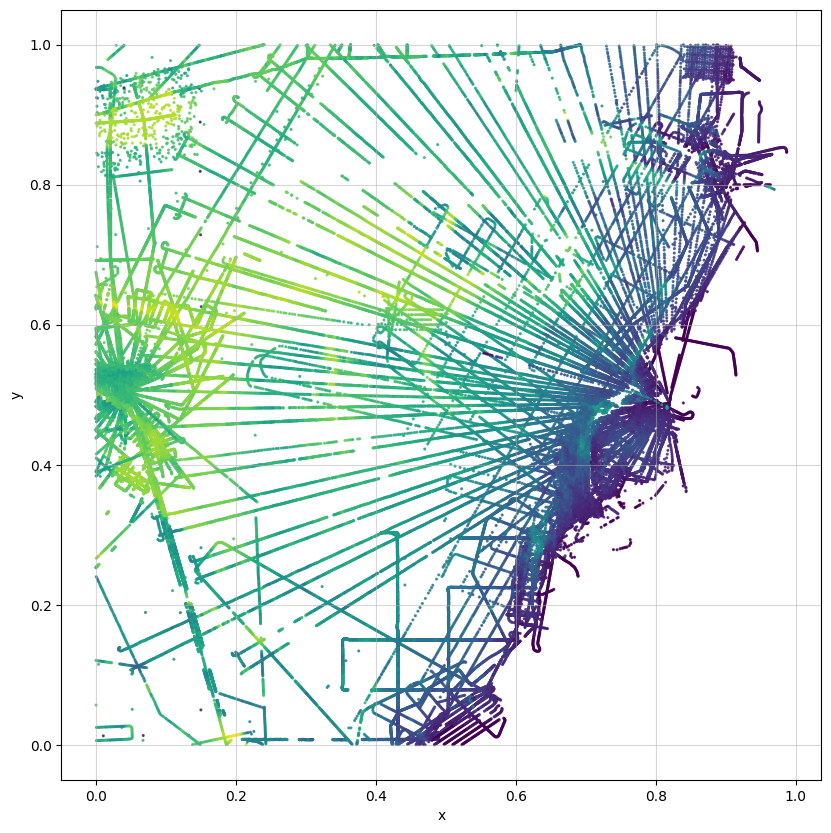

In [101]:
fig, ax = plt.subplots(figsize = (10, 10))

REDUCE_RATE = 100

ax.scatter(
    ice[:, 0][::REDUCE_RATE], 
    ice[:, 1][::REDUCE_RATE], 
    c = ice[:, 2][::REDUCE_RATE], 
    s = 1.5, alpha = 0.8, cmap = 'viridis')

# Optional: label axes to clarify units
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)  # Show gridlines

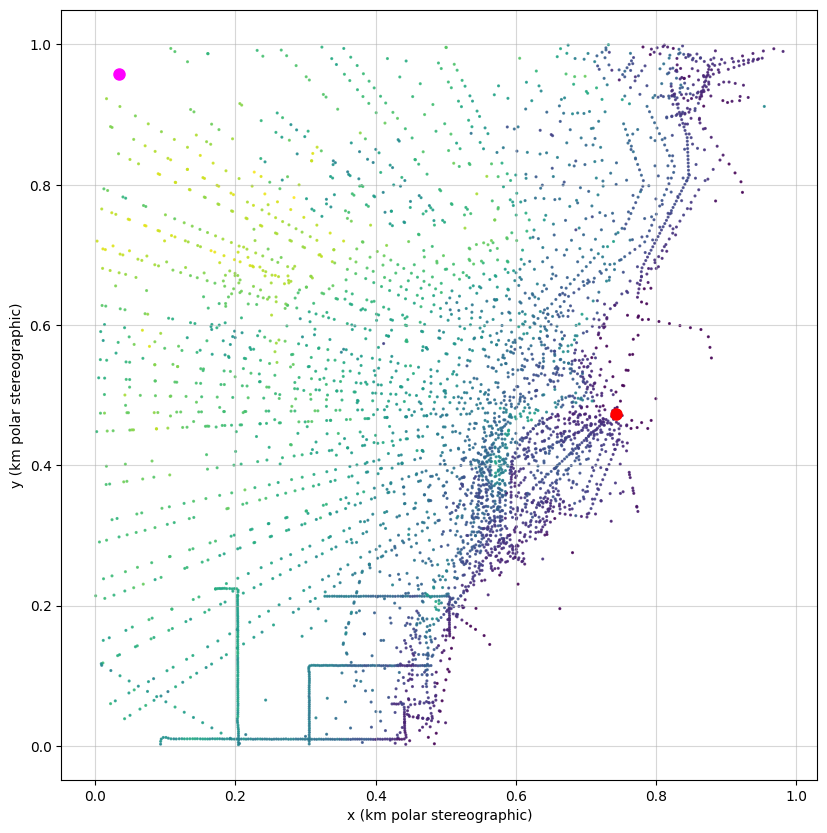

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(
    ice[:, 0][::REDUCE_RATE], 
    ice[:, 1][::REDUCE_RATE], 
    c = ice[:, 2][::REDUCE_RATE], 
    s = 1.5, alpha = 0.8, cmap = 'viridis')

ax.plot(
    candidate[:, 0], 
    candidate[:, 1], 
    color = "magenta", 
    marker = "o", 
    markersize = 8, 
    linestyle = "None",
    label = "Candidate")

ax.plot(skiway_x_norm, skiway_y_norm, "ro", markersize = 8, label = "Casey skiway")

# Optional: label axes to clarify units
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)  # Show gridlines

# Bounds

- discrete sec of points
- add term over water?

from botorch.optim.optimize import optimize_acqf_discrete
import torch

# 1) Generate candidate pool in a box
pool = torch.rand(2000, 2) * (ub - lb) + lb  # (N, d)

# 2) Keep only feasible points
feasible = pool[mask_bool(pool)]             # implement mask_bool with your polygon / raster mask

# 3) Maximise over discrete set
cand, acq = optimize_acqf_discrete(
    acq_function=logNEI,
    choices=feasible.unsqueeze(1),  # (N, q=1, d)
    q=1,
)

## Batch BO

Not compatible withh all aquisition functions

In [18]:
NUM_BATCH = 20
from botorch.acquisition.monte_carlo import qExpectedImprovement

qEI = qExpectedImprovement(model = gp, best_f = ice_reduced[:, 2].max())

candidates, acq_values = optimize_acqf(
    acq_function = qEI,
    bounds = bounds,
    # Batch
    q = NUM_BATCH,
    num_restarts = 10,
    raw_samples = 128,
)

print(candidates.shape)

/home/kim/anaconda3/envs/bo4ais_env/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:394: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


torch.Size([20, 2])


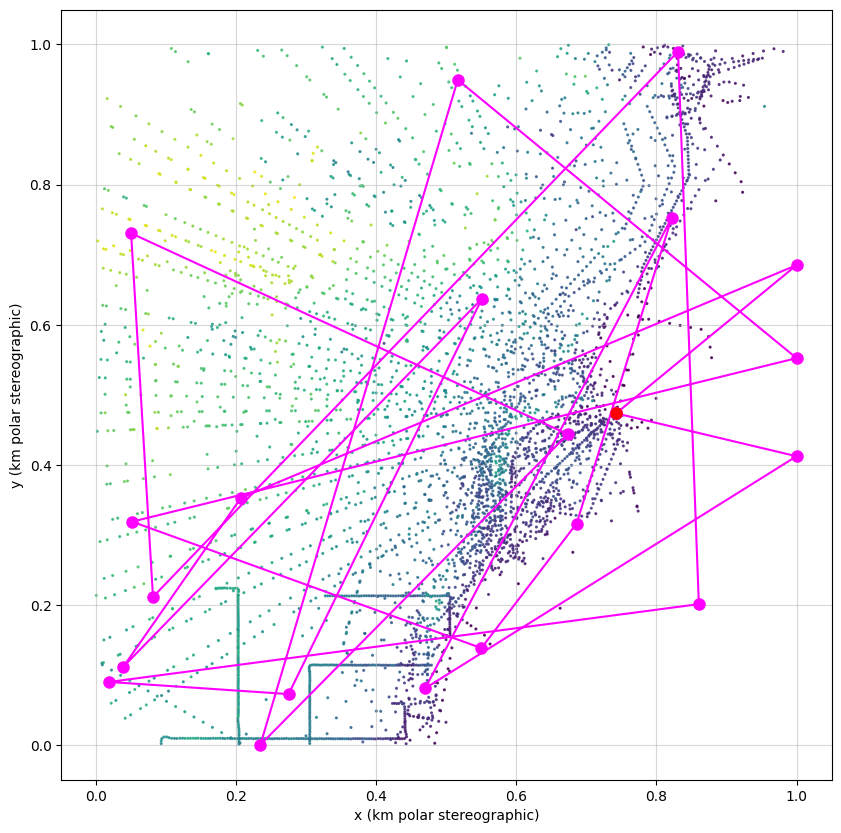

In [27]:
CONNECT_LINES = True
if CONNECT_LINES:
    # Add skiway as start and end point
    candidates = torch.concat((skiway, candidates, skiway), dim = 0)

fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(
    ice_reduced[:, 0], 
    ice_reduced[:, 1], 
    c = ice_reduced[:, 2], 
    s = 1.5, alpha = 0.8, cmap = 'viridis')

ax.plot(
    candidates[:, 0], 
    candidates[:, 1], 
    color = "magenta", 
    marker = "o", 
    markersize = 8, 
    linestyle = "solid" if CONNECT_LINES else "None",  # <- disables line
    label = "Candidate")

ax.plot(skiway_x_norm, skiway_y_norm, "ro", markersize = 8, label = "Casey skiway")

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)  # Show gridlines

# Show aquisition function

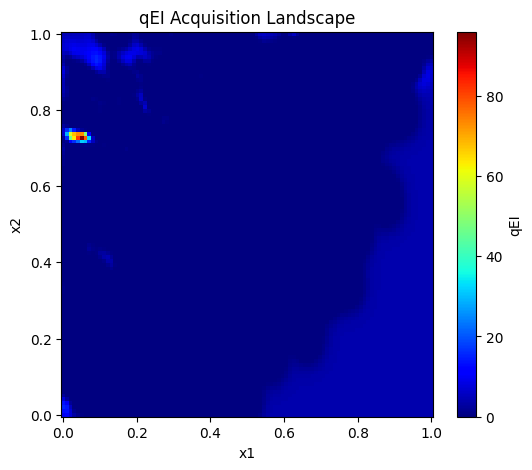

In [31]:
import torch
import matplotlib.pyplot as plt

# --- 2. Make a grid over [0,1]^2 (assuming you've normalised inputs) ---
grid_size = 100
x1 = torch.linspace(0, 1, grid_size)
x2 = torch.linspace(0, 1, grid_size)
X1, X2 = torch.meshgrid(x1, x2, indexing = "ij")
grid = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

# --- 3. Evaluate acquisition function ---
with torch.no_grad():
    acq_values = qEI(grid.unsqueeze(1))  # shape [N, 1]
acq_values = acq_values.view(grid_size, grid_size).cpu()

# --- 4. Plot ---
plt.figure(figsize=(6,5))
pcm = plt.pcolormesh(x1, x2, acq_values.T, shading = "auto", cmap = "jet")
plt.colorbar(pcm, label = "qEI")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("qEI Acquisition Landscape")
plt.show()

# ToDo:

- bounds: ice sheet only
    - With accept/reject
    - constraint https://archive.botorch.org/v/0.9.2/api/_modules/botorch/optim/parameter_constraints.html
- new aquisition function
- EI function: outlier in data? so focused function